In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image
import matplotlib.pyplot as plt
import json

In [5]:
vgg16 = models.vgg16(pretrained = True)
vgg16.eval()

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/charlotteimbert/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|████████████████████████████████████████| 528M/528M [00:27<00:00, 20.1MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
# 2. Load ImageNet labels (1000 class names) so you can decode output
with open('imagenet_classes.txt') as f:
    idx2label = [line.strip() for line in f.readlines()]

# 3. Define transform (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

In [13]:
# 4. Load one example image from TinyImageNet
img = Image.open('tiny-imagenet-200/val/images/val_0.JPEG').convert('RGB')
img_transformed = transform(img).unsqueeze(0)  # [1, 3, 224, 224]

In [15]:
# 5. Predict
with torch.no_grad():
    output = vgg16(img_transformed)

bobsled: 0.1687
stretcher: 0.0596
snowmobile: 0.0459
thresher: 0.0397
chain saw: 0.0324


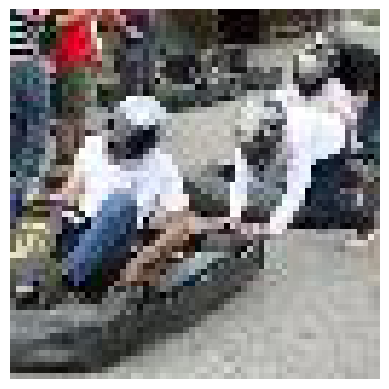

In [17]:
# 6. Decode top-5 predictions
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)

for i in range(top5_prob.size(0)):
    print(f"{idx2label[top5_catid[i]]}: {top5_prob[i].item():.4f}")

# 7. (Optional) Show the image
plt.imshow(img)
plt.axis('off')
plt.show()

In [19]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import random

# --------- Setup ---------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained VGG16
vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()

# Load ImageNet class names (download this file if you don't have it)
with open('imagenet_classes.txt') as f:
    idx2label = [line.strip() for line in f.readlines()]

# Load val_annotations.txt to map val images to WNIDs
val_annotations = {}
with open('tiny-imagenet-200/val/val_annotations.txt', 'r') as f:
    for line in f.readlines():
        parts = line.strip().split('\t')
        filename, wnid = parts[0], parts[1]
        val_annotations[filename] = wnid

# Load wnid -> human-readable label from words.txt
wnid_to_label = {}
with open('tiny-imagenet-200/words.txt', 'r') as f:
    for line in f.readlines():
        wnid, label = line.strip().split('\t')
        wnid_to_label[wnid] = label

# Transform for VGG16
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Path to validation images
val_img_dir = 'tiny-imagenet-200/val/images'

# --------- Evaluate ---------
all_val_images = os.listdir(val_img_dir)
sampled_images = random.sample(all_val_images, 50)  # sample 50 random images

correct = 0

for img_file in sampled_images:
    img_path = os.path.join(val_img_dir, img_file)
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = vgg16(input_tensor)

    probs = torch.nn.functional.softmax(output[0], dim=0)
    top1_prob, top1_catid = torch.topk(probs, 1)

    pred_label = idx2label[top1_catid.item()]
    true_wnid = val_annotations[img_file]
    true_label = wnid_to_label.get(true_wnid, 'unknown')

    print(f"Image: {img_file}")
    print(f"True: {true_label}")
    print(f"Pred: {pred_label} ({top1_prob.item():.4f})")
    print("-" * 40)

    # Quick matching heuristic: check if true label *word* appears inside pred_label
    if true_label.split(',')[0].lower() in pred_label.lower():
        correct += 1

print(f"\nRough Top-1 Match Accuracy: {correct}/{len(sampled_images)} = {correct/len(sampled_images):.2%}")


Image: val_4861.JPEG
True: European fire salamander, Salamandra salamandra
Pred: European fire salamander (0.3545)
----------------------------------------
Image: val_7057.JPEG
True: crane
Pred: steel arch bridge (0.4083)
----------------------------------------
Image: val_5973.JPEG
True: chain
Pred: chain (0.3870)
----------------------------------------
Image: val_1411.JPEG
True: seashore, coast, seacoast, sea-coast
Pred: grey whale (0.3463)
----------------------------------------
Image: val_8117.JPEG
True: picket fence, paling
Pred: worm fence (0.3258)
----------------------------------------
Image: val_1219.JPEG
True: kimono
Pred: overskirt (0.1684)
----------------------------------------
Image: val_8887.JPEG
True: slug
Pred: tailed frog (0.3902)
----------------------------------------
Image: val_7359.JPEG
True: ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle
Pred: ant (0.4878)
----------------------------------------
Image: val_8233.JPEG
True: pole
Pred: worm fence 

In [ ]:
# --- IMPORTS ---
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms.functional import rgb_to_grayscale
from PIL import Image
import os
import numpy as np
import pandas as pd
from collections import defaultdict

# --- DEVICE SETUP ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- LOAD MODEL ---
vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()

# --- SETUP HOOKS ---
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Hook conv layers
for idx, layer in enumerate(vgg16.features):
    if isinstance(layer, torch.nn.Conv2d):
        layer.register_forward_hook(get_activation(f'conv{idx}'))

# --- TRANSFORMS ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def to_grayscale(img_tensor):
    return rgb_to_grayscale(img_tensor, num_output_channels=3)

# --- FUNCTIONS ---

def gather_color_activations(image_paths):
    """
    Pass images through VGG16 and store mean activations per neuron.
    """
    color_acts = defaultdict(lambda: defaultdict(list))

    for img_path in image_paths:
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            vgg16(img_tensor)

        for layer_name, act in activations.items():
            mean_act = act.mean(dim=[0, 2, 3]).squeeze(0).cpu().numpy()  # [channels]
            for neuron_idx, act_val in enumerate(mean_act):
                color_acts[layer_name][neuron_idx].append((img_path, act_val))

    return color_acts

def compute_true_csi(color_acts, top_n=50):
    """
    Given color activations, compute true CSI based on top-N images per neuron.
    """
    true_csi = defaultdict(dict)

    for layer_name, neurons in color_acts.items():
        for neuron_idx, img_act_list in neurons.items():
            # Sort images by activation strength (highest first)
            img_act_list = sorted(img_act_list, key=lambda x: x[1], reverse=True)

            top_imgs = [img for img, _ in img_act_list[:top_n]]

            sum_color = 0
            sum_gray = 0

            for img_path in top_imgs:
                img = Image.open(img_path).convert('RGB')
                img_tensor = transform(img).unsqueeze(0).to(device)
                input_gray = to_grayscale(transform(img)).unsqueeze(0).to(device)

                with torch.no_grad():
                    vgg16(img_tensor)
                    color_mean = activations[layer_name].mean(dim=[0, 2, 3])[0, neuron_idx]

                    vgg16(input_gray)
                    gray_mean = activations[layer_name].mean(dim=[0, 2, 3])[0, neuron_idx]

                sum_color += color_mean.item()
                sum_gray += gray_mean.item()

            csi = 1 - (sum_gray / (sum_color + 1e-8))
            true_csi[layer_name][neuron_idx] = csi

    return true_csi

In [ ]:
def compute_activation_curve(img_paths, transform_func, steps, layer_name, neuron_idx):
    """
    Pass top-N images with perturbations and compute mean activation at each step.
    """
    responses = []

    for s in steps:
        step_activations = []
        for img_path in img_paths:
            img = Image.open(img_path).convert('RGB')
            img_transformed = transform_func(img, s)
            input_tensor = transform(img_transformed).unsqueeze(0).to(device)

            with torch.no_grad():
                vgg16(input_tensor)

            mean_act = activations[layer_name].mean(dim=[0, 2, 3])[0, neuron_idx]
            step_activations.append(mean_act.item())

        mean_response = np.mean(step_activations)
        responses.append(mean_response)

    return responses

def plot_activation_curve(responses, steps, layer_name, neuron_idx):
    plt.figure(figsize=(6,4))
    plt.plot(steps, responses, marker='o')
    plt.title(f'Neuron {neuron_idx} in {layer_name}\nResponse Curve')
    plt.xlabel('Perturbation')
    plt.ylabel('Mean Activation')
    plt.grid(True)
    plt.show()

In [ ]:
def save_csi_to_csv(true_csi, output_path='csi_results.csv'):
    """
    Save true CSI results into a clean CSV file.
    Each row = one neuron (layer, neuron_idx, CSI value).
    """
    records = []

    for layer_name, neurons in true_csi.items():
        for neuron_idx, csi_value in neurons.items():
            records.append({
                'layer': layer_name,
                'neuron_idx': neuron_idx,
                'csi': csi_value
            })

    df = pd.DataFrame(records)
    df.to_csv(output_path, index=False)
    print(f"Saved CSI results to {output_path}")

In [ ]:
df = pd.read_csv('csi_results.csv')

# Mean CSI per layer
mean_csi = df.groupby('layer')['csi'].mean()
print(mean_csi)

# Histogram of CSI for a specific layer
import matplotlib.pyplot as plt

layer = 'conv5'
df_layer = df[df['layer'] == layer]

plt.hist(df_layer['csi'], bins=20)
plt.title(f'CSI Distribution in {layer}')
plt.xlabel('CSI')
plt.ylabel('Number of Neurons')
plt.grid(True)
plt.show()

In [5]:
# load the pre-trained VGG16 and specify which layer we'll extract feature activations from

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

# Load pretrained VGG16
vgg16 = models.vgg16(pretrained=True).eval()

# Select the layer from which we want to extract neuron activations (e.g., conv5_3)
target_layer = 28  # conv5_3 is the 29th layer in features (index 28)

# Truncate model at selected layer
vgg16_truncated = nn.Sequential(*list(vgg16.features.children())[:target_layer + 1])

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_truncated = vgg16_truncated.to(device)

print(f"VGG16 truncated at layer {target_layer} and moved to {device}.")

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16 truncated at layer 28 and moved to cpu.


In [7]:
# transform tinyimagenet validation images so that they are in the correct shape and size for VGG16; the class allows the transformation to be applied to all 10,000 images
from torchvision.datasets.folder import default_loader

# Define transform: resize to 224x224 (VGG16 input size), convert to tensor, normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to VGG16 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Custom Dataset to load images from a folder
class TinyImageNetValDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = sorted([
            os.path.join(image_dir, fname)
            for fname in os.listdir(image_dir)
            if fname.endswith(".JPEG")
        ])
        self.transform = transform
        self.loader = default_loader

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.loader(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]  # return path for identification

# Set path to your TinyImageNet val/images folder
image_dir = "/Users/charlotteimbert/Documents/SP2025/NEUR189B/tiny-imagenet-200/val/images"

# Create dataset and dataloader
dataset = TinyImageNetValDataset(image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

print(f"Loaded {len(dataset)} images from validation set.")

Loaded 10000 images from validation set.


In [9]:
# create a hook to extract activations from neurons in specific layer; hook captures the layer outputs

import torch
import torchvision.models as models
import torch.nn as nn

# Load pretrained VGG16
vgg16 = models.vgg16(pretrained=True).eval().to(device)

# Choose layer name, e.g., last convolutional layer
layer_name = 'features.28'
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register the hook
layer = dict([*vgg16.named_modules()])[layer_name]
layer.register_forward_hook(get_activation(layer_name))

In [11]:
# pass val images through the model and get activations

from torch.utils.data import DataLoader
from tqdm import tqdm

activation_list = []
image_paths = []

# Adjust batch size as needed
loader = DataLoader(dataset, batch_size=16, shuffle=False)

with torch.no_grad():
    for images, paths in tqdm(loader):
        images = images.to(device)
        _ = vgg16(images)  # forward pass
        batch_acts = activations[layer_name].cpu()  # shape: [B, C, H, W]
        
        activation_list.extend(batch_acts)
        image_paths.extend(paths)

100%|█████████████████████████████████████████| 625/625 [16:21<00:00,  1.57s/it]


In [13]:
import numpy as np
import torchvision.transforms.functional as TF

def get_top_patches(activation_list, image_paths, dataset, top_k=100):
    neuron_patches = {}  # dict: neuron_idx -> list of patches

    for neuron_idx in range(activation_list[0].shape[0]):
        activations = []
        for i, act in enumerate(activation_list):
            max_val = act[neuron_idx].max().item()
            activations.append((max_val, i))

        # Sort and get top_k
        top_k_indices = sorted(activations, key=lambda x: x[0], reverse=True)[:top_k]

        patches = []
        for _, img_idx in top_k_indices:
            img_path = image_paths[img_idx]
            original_img = Image.open(img_path).convert('RGB')
            original_img = transform(original_img)  # same transform as dataset
            patch_size = act.shape[1:]  # (H, W) of feature map
            scale_factor = dataset[0][0].shape[1] / patch_size[1]  # image / activation width

            # Get max location (x, y)
            act_map = activation_list[img_idx][neuron_idx]
            y, x = np.unravel_index(torch.argmax(act_map).item(), act_map.shape)

            # Convert to pixel coordinates
            x1 = int(x * scale_factor)
            y1 = int(y * scale_factor)
            x2 = x1 + int(scale_factor)
            y2 = y1 + int(scale_factor)

            # Clip and crop
            x1, y1, x2, y2 = map(lambda v: max(0, min(v, original_img.shape[1])), [x1, y1, x2, y2])
            patch = TF.crop(original_img, y1, x1, y2 - y1, x2 - x1)
            patches.append(patch)

        neuron_patches[neuron_idx] = patches

    return neuron_patches

In [27]:
neuron_patches = get_top_patches(activation_list, image_paths, dataset)

In [37]:
from torchvision.transforms import ToTensor, ToPILImage
import torch

def compute_neuron_features(neuron_patches, activation_list, top_k=100):
    neuron_features = {}

    for neuron_idx, patches in neuron_patches.items():
        if len(patches) == 0:
            continue

        # Convert patches to tensors and stack
        patch_tensors = torch.stack([
            p if isinstance(p, torch.Tensor) else ToTensor()(p)
            for p in patches
        ])

        # Optionally use activations to weight patches
        activations = []
        for img_idx in range(top_k):
            act_map = activation_list[img_idx][neuron_idx]
            max_val = act_map.max().item()
            activations.append(max_val)

        activations = torch.tensor(activations)
        norm_activations = activations / activations.sum()

        # Compute weighted average (neuron feature)
        nf = (patch_tensors * norm_activations[:, None, None, None]).sum(dim=0)  # shape: (3, H, W)
        neuron_features[neuron_idx] = nf

    return neuron_features

In [39]:
def visualize_neuron_feature(nf_tensor):
    img = ToPILImage()(nf_tensor.clamp(0,1))  # convert to PIL and clip to [0,1]
    img.show()

In [41]:
neuron_features = compute_neuron_features(neuron_patches, activation_list)
visualize_neuron_feature(neuron_features[0])

In [49]:
import os
import torch
import gc
from torchvision.transforms import ToPILImage

def save_neuron_features(neuron_features, out_dir="neuron_features", max_to_save=None):
    os.makedirs(out_dir, exist_ok=True)
    for i, (neuron_idx, nf_tensor) in enumerate(neuron_features.items()):
        if max_to_save is not None and i >= max_to_save:
            break
        nf_tensor = nf_tensor.cpu().clamp(0, 1)  # move to CPU and clip
        img = ToPILImage()(nf_tensor)
        img.save(os.path.join(out_dir, f"neuron_{neuron_idx}.png"))
        del nf_tensor, img
        gc.collect()

In [51]:
save_neuron_features(neuron_features, max_to_save=100)

In [53]:
from IPython.display import display, Image
import os

image_dir = "neuron_features"

# Make sure the directory exists
if not os.path.exists(image_dir):
    print(f"Directory '{image_dir}' does not exist.")
else:
    for i in range(100):
        img_path = os.path.join(image_dir, f"neuron_{i}.png")
        if os.path.isfile(img_path):
            display(Image(filename=img_path))
        else:
            print(f"Image {img_path} not found.")

In [55]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import torch
from PIL import Image
import os

def create_neuron_grid(neuron_features, grid_size=(10, 10), out_path="neuron_grid.png"):
    fig, axes = plt.subplots(*grid_size, figsize=(20, 20))
    axes = axes.flatten()

    for i, (neuron_idx, nf_tensor) in enumerate(neuron_features.items()):
        if i >= grid_size[0] * grid_size[1]:
            break
        nf_tensor = nf_tensor.cpu().clamp(0, 1)
        img = ToPILImage()(nf_tensor)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Neuron {neuron_idx}", fontsize=8)

    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()
    print(f"Saved neuron grid to {out_path}")

In [57]:
create_neuron_grid(neuron_features, grid_size=(10, 10), out_path="neuron_grid.png")

Saved neuron grid to neuron_grid.png
